In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Sep  15 08:50:58 2021
@author: zeqinhuang
"""

import xarray as xr
import numpy as np
import pandas as pd
import os
import proplot as pplot
import cmaps
from matplotlib import pyplot as plt
from scipy.stats import norm
import glob
import matplotlib as mpl
import xesmf as xe
from cartopy.util import add_cyclic_point
from scipy.stats import linregress
from scipy.stats import theilslopes
import geopandas as gp
import seaborn as sns
import random
from warnings import simplefilter

import matplotlib.patches as pch
import cartopy
import cartopy.crs as ccrs
mapcrs = ccrs.PlateCarree(central_longitude=0, globe=None)
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from utils import *

simplefilter(action='ignore', category=FutureWarning)

In [2]:
def cal_variance(data):
    variance = xr.apply_ufunc(np.var,
                            data,
                            vectorize=True,
                            dask='parallelized', 
                            input_core_dims=[['time']],
                            output_dtypes=[float],
                            )
    return variance

In [3]:
def _cal_var(data1,data2):
    cov = np.cov(data1,data2)[0,1]
    return cov
def cal_covar(data1,data2):
    variance = xr.apply_ufunc(_cal_var,
                            data1,data2,
                            vectorize=True,
                            dask='parallelized', 
                            input_core_dims=[['time'],['time']],
                            output_dtypes=[float]
                            )
    return variance

In [4]:
# EP event for a given grid is calculated as the average of its nearby grids
# https://doi. org/10.1029/2021GL095503
def reshape_for_variance(data):
    value1 = data.values
    value2 = np.concatenate((value1[:,:,[-1]],value1[:,:,:-1]),axis=2)
    value3 = np.concatenate((value1[:,:,1:],value1[:,:,[0]]),axis=2)
    value4 = np.concatenate((value1[:,[0],:],value1[:,:-1,:]),axis=1)
    value5 = np.concatenate((value1[:,1:,:],value1[:,[-1],:]),axis=1)
    value6 = np.concatenate((value3[:,[0],:],value3[:,:-1,:]),axis=1)
    value7 = np.concatenate((value3[:,1:,:],value3[:,[-1],:]),axis=1)
    value8 = np.concatenate((value2[:,[0],:],value2[:,:-1,:]),axis=1)
    value9 = np.concatenate((value2[:,1:,:],value2[:,[-1],:]),axis=1)
    value = (value1 + value2 + value3 + value4 + value5 + value6 + value7 + value8 + value9) / 9
    data.values = value
    return data

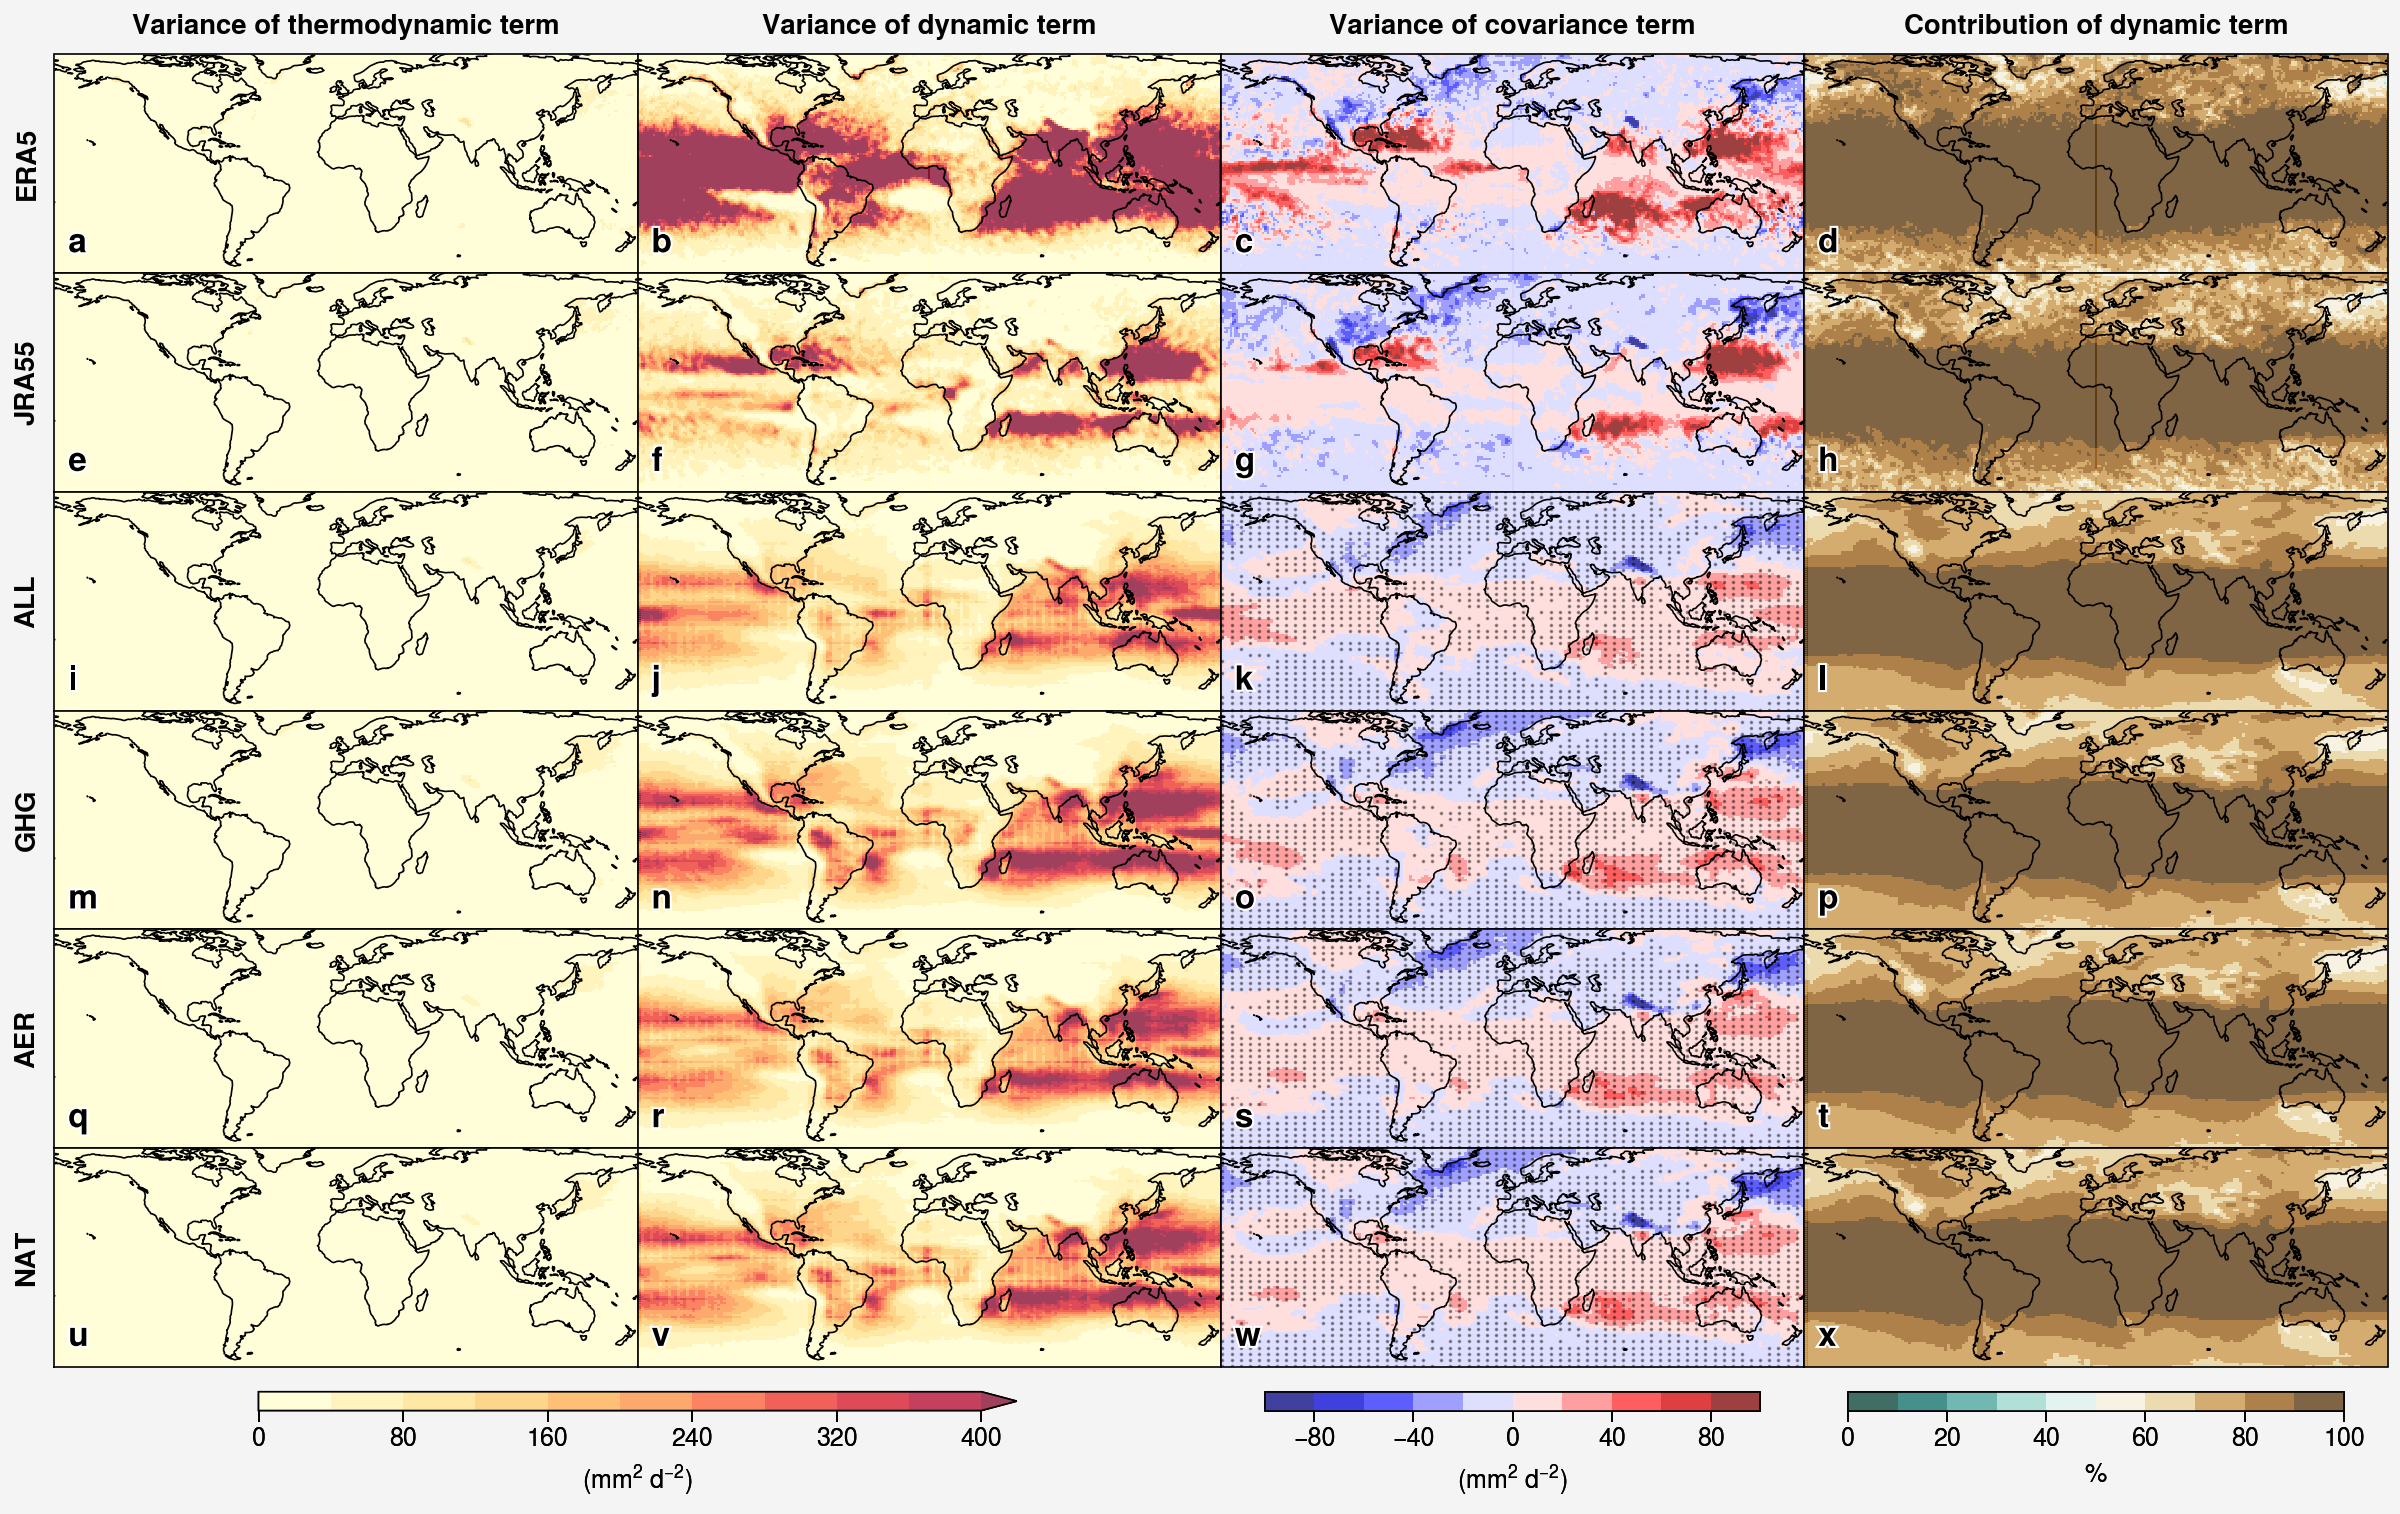

In [6]:
fig, axs = pplot.subplots(ncols=4,nrows=6,wratios=(1,1,1,1),wspace=0,hspace=0,share=False,
                        proj='pcarree',width=12)
axs.format(grid=False)
axs.format(abc=True,abcsize=12,abcloc='ll')

vmax1=100
vmin1=-100
levels1=11

vmax=400
vmin=0
levels=11

vmax2=100
vmin2=0
levels2=11

forcing_list = ['era5','jra55','historical','hist-GHG','hist-aer','hist-nat']
name_list    = ['scaling_thermo','scaling_dynamic','covariance','contribution']

ax_locs  = {
    'era5':{'scaling_thermo':0,'scaling_dynamic':1,'covariance':2,'contribution':3},
    'jra55':{'scaling_thermo':4,'scaling_dynamic':5,'covariance':6,'contribution':7},
    'historical':{'scaling_thermo':8,'scaling_dynamic':9,'covariance':10,'contribution':11},
    'hist-GHG':{'scaling_thermo':12,'scaling_dynamic':13,'covariance':14,'contribution':15},
    'hist-aer':{'scaling_thermo':16,'scaling_dynamic':17,'covariance':18,'contribution':19},
    'hist-nat':{'scaling_thermo':20,'scaling_dynamic':21,'covariance':22,'contribution':23}}

for f in forcing_list:
    forcing  = f
    if forcing == 'era5':
        src_id = 'era5'
        run = 'reanalysis'
        # scaling_thermo
        n = name_list[0]
        file = glob.glob(forcing_dir[f] + n +'_day'+'*' + src_id + '*' + run + '*.nc')[0]
        scaling_thermo = xr.open_dataarray(file)
        scaling_thermo = scaling_thermo.rename({'longitude':'lon','latitude':'lat'})
        scaling_thermo = scaling_thermo * 86400
        scaling_thermo = reshape_for_variance(scaling_thermo)
        scaling_thermo_var = cal_variance(scaling_thermo)
        lon = scaling_thermo_var['lon']
        lats1d = scaling_thermo_var['lat']
        data1  = scaling_thermo_var
        data1, lons1d = add_cyclic_point(data1, coord=lon)
        data1[:,-2] = (data1[:,-3] + data1[:,-1]) / 2
        ax_loc = ax_locs[f][n]
        p = axs[ax_loc].pcolormesh(lons1d,lats1d,data1,levels = [i for i in np.linspace(vmin,vmax,levels)],alpha=0.75,
                            extend = 'neither',cmap=cmaps.MPL_YlOrRd) #CBR_wet #WhiteYellowOrangeRed
        axs[ax_loc].format(coast=True, lonlim=(-180,180), latlim=(-60.001,75),labels=False, lonlines=60, latlines=30)

        # scaling_dynamic
        n = name_list[1]
        file = glob.glob(forcing_dir[f] + n +'_day'+'*' + src_id + '*' + run + '*.nc')[0]
        scaling_dynamic = xr.open_dataarray(file)
        scaling_dynamic = scaling_dynamic.rename({'longitude':'lon','latitude':'lat'})
        scaling_dynamic = scaling_dynamic * 86400
        scaling_dynamic = reshape_for_variance(scaling_dynamic)
        scaling_dynamic_var = cal_variance(scaling_dynamic)
        lon = scaling_dynamic_var['lon']
        lats1d = scaling_dynamic_var['lat']
        data1  = scaling_dynamic_var
        data1, lons1d = add_cyclic_point(data1, coord=lon)
        data1[:,-2] = (data1[:,-3] + data1[:,-1]) / 2
        ax_loc = ax_locs[f][n]
        p = axs[ax_loc].pcolormesh(lons1d,lats1d,data1,levels = [i for i in np.linspace(vmin,vmax,levels)],alpha=0.75,
                            extend = 'neither',cmap=cmaps.MPL_YlOrRd) #CBR_wet #WhiteYellowOrangeRed
        axs[ax_loc].format(coast=True, lonlim=(-180,180), latlim=(-60.001,75),labels=False, lonlines=60, latlines=30)

        # covariance
        n = name_list[2]
        var0_cov = cal_covar(scaling_thermo,scaling_dynamic)
        lon = var0_cov['lon']
        lats1d = var0_cov['lat']
        data1  = 2 * var0_cov
        data1, lons1d = add_cyclic_point(data1, coord=lon)
        data1[:,-2] = (data1[:,-3] + data1[:,-1]) / 2
        ax_loc = ax_locs[f][n]
        p1 = axs[ax_loc].pcolormesh(lons1d,lats1d,data1,levels = [i for i in np.linspace(vmin1,vmax1,levels1)],alpha=0.75,
                            extend = 'neither',cmap=cmaps.NCV_blue_red)
        axs[ax_loc].format(coast=True, lonlim=(-180,180), latlim=(-60.001,75),labels=False, lonlines=60, latlines=30)

        variance_all = scaling_thermo_var + scaling_dynamic_var

        # explained by scaling_dynamic
        n = name_list[3]
        lon = scaling_dynamic_var['lon']
        lats1d = scaling_dynamic_var['lat']
        data1  = scaling_dynamic_var / variance_all * 100
        data1, lons1d = add_cyclic_point(data1, coord=lon)
        data1[:,-2] = (data1[:,-3] + data1[:,-1]) / 2
        ax_loc = ax_locs[f][n]
        p = axs[ax_loc].pcolormesh(lons1d,lats1d,data1,levels = [i for i in np.linspace(vmin2,vmax2,levels2)],alpha=0.75,
                            extend = 'neither',cmap=cmaps.MPL_BrBG_r) #CBR_wet #WhiteYellowOrangeRed
        axs[ax_loc].format(coast=True, lonlim=(-180,180), latlim=(-60.001,75),labels=False, lonlines=60, latlines=30)

    elif forcing == 'jra55':
        src_id = 'jra55'
        run = 'reanalysis'
        # scaling_thermo
        n = name_list[0]
        file = glob.glob(forcing_dir[f] + n +'_day'+'*' + src_id + '*' + run + '*.nc')[0]
        scaling_thermo = xr.open_dataarray(file)
        scaling_thermo = scaling_thermo * 86400
        scaling_thermo = reshape_for_variance(scaling_thermo)
        scaling_thermo_var = cal_variance(scaling_thermo)
        lon = scaling_thermo_var['lon']
        lats1d = scaling_thermo_var['lat']
        data1  = scaling_thermo_var
        data1, lons1d = add_cyclic_point(data1, coord=lon)
        data1[:,-2] = (data1[:,-3] + data1[:,-1]) / 2
        ax_loc = ax_locs[f][n]
        p = axs[ax_loc].pcolormesh(lons1d,lats1d,data1,levels = [i for i in np.linspace(vmin,vmax,levels)],alpha=0.75,
                            extend = 'neither',cmap=cmaps.MPL_YlOrRd) #CBR_wet #WhiteYellowOrangeRed
        axs[ax_loc].format(coast=True, lonlim=(-180,180), latlim=(-60.001,75),labels=False, lonlines=60, latlines=30)

        # scaling_dynamic
        n = name_list[1]
        file = glob.glob(forcing_dir[f] + n +'_day'+'*' + src_id + '*' + run + '*.nc')[0]
        scaling_dynamic = xr.open_dataarray(file)
        scaling_dynamic = scaling_dynamic * 86400
        scaling_dynamic = reshape_for_variance(scaling_dynamic)
        scaling_dynamic_var = cal_variance(scaling_dynamic)
        lon = scaling_dynamic_var['lon']
        lats1d = scaling_dynamic_var['lat']
        data1  = scaling_dynamic_var
        data1, lons1d = add_cyclic_point(data1, coord=lon)
        data1[:,-2] = (data1[:,-3] + data1[:,-1]) / 2
        ax_loc = ax_locs[f][n]
        p = axs[ax_loc].pcolormesh(lons1d,lats1d,data1,levels = [i for i in np.linspace(vmin,vmax,levels)],alpha=0.75,
                            extend = 'neither',cmap=cmaps.MPL_YlOrRd) #CBR_wet #WhiteYellowOrangeRed
        axs[ax_loc].format(coast=True, lonlim=(-180,180), latlim=(-60.001,75),labels=False, lonlines=60, latlines=30)

        # covariance
        n = name_list[2]
        var0_cov = cal_covar(scaling_thermo,scaling_dynamic)
        lon = var0_cov['lon']
        lats1d = var0_cov['lat']
        data1  = 2 * var0_cov
        data1, lons1d = add_cyclic_point(data1, coord=lon)
        data1[:,-2] = (data1[:,-3] + data1[:,-1]) / 2
        ax_loc = ax_locs[f][n]
        p1 = axs[ax_loc].pcolormesh(lons1d,lats1d,data1,levels = [i for i in np.linspace(vmin1,vmax1,levels1)],alpha=0.75,
                            extend = 'neither',cmap=cmaps.NCV_blue_red)
        axs[ax_loc].format(coast=True, lonlim=(-180,180), latlim=(-60.001,75),labels=False, lonlines=60, latlines=30)

        variance_all = scaling_thermo_var + scaling_dynamic_var

        # explained by scaling_dynamic
        n = name_list[3]
        lon = scaling_dynamic_var['lon']
        lats1d = scaling_dynamic_var['lat']
        data1  = scaling_dynamic_var / variance_all * 100
        data1, lons1d = add_cyclic_point(data1, coord=lon)
        data1[:,-2] = (data1[:,-3] + data1[:,-1]) / 2
        ax_loc = ax_locs[f][n]
        p = axs[ax_loc].pcolormesh(lons1d,lats1d,data1,levels = [i for i in np.linspace(vmin2,vmax2,levels2)],alpha=0.75,
                            extend = 'neither',cmap=cmaps.MPL_BrBG_r) #CBR_wet #WhiteYellowOrangeRed
        axs[ax_loc].format(coast=True, lonlim=(-180,180), latlim=(-60.001,75),labels=False, lonlines=60, latlines=30)

    else:
        ensemble = ensembles[f]
        ensemble = [i+'_'+filepath[-12:-3] for i in ensemble for filepath in glob.glob(forcing_dir[forcing] + 'prec' + '_day_' + i + '*.nc')]
        ens_num  = len(ensemble)

        mmm_scaling_thermo  = 0
        mmm_scaling_dynamic  = 0
        mmm_covariance  = 0
        mmm_contribution  = 0
        acc_sign_up_num = 0
        acc_sign_down_num = 0
        
        for i in ensemble:
            src_id = i.split('_')[0]
            run    = i.split('_')[2]
            pi_time = i.split('_')[3]
            if f=='historical' and src_id == 'ACCESS-ESM1-5':
                ens_num = ens_num - 1
                continue

            # scaling_thermo
            n = name_list[0]
            file = glob.glob(forcing_dir[f] + n +'_day'+'*' + src_id + '*' + run + '*.nc')[0]
            scaling_thermo = xr.open_dataarray(file)
            scaling_thermo = Regridder(scaling_thermo)
            scaling_thermo = scaling_thermo.interpolate_na(dim="lon", method="linear",fill_value="extrapolate")
            scaling_thermo = scaling_thermo * 86400
            scaling_thermo = reshape_for_variance(scaling_thermo)
            scaling_thermo_var = cal_variance(scaling_thermo)
            mmm_scaling_thermo   = mmm_scaling_thermo + scaling_thermo_var

            # scaling_dynamic
            n = name_list[1]
            file = glob.glob(forcing_dir[f] + n +'_day'+'*' + src_id + '*' + run + '*.nc')[0]
            scaling_dynamic = xr.open_dataarray(file)
            scaling_dynamic = Regridder(scaling_dynamic)
            scaling_dynamic = scaling_dynamic.interpolate_na(dim="lon", method="linear",fill_value="extrapolate")
            scaling_dynamic = scaling_dynamic * 86400
            scaling_dynamic = reshape_for_variance(scaling_dynamic)
            scaling_dynamic_var = cal_variance(scaling_dynamic)
            mmm_scaling_dynamic   = mmm_scaling_dynamic + scaling_dynamic_var

            # covariance
            var0_cov = cal_covar(scaling_thermo,scaling_dynamic)
            mmm_covariance   = mmm_covariance + var0_cov
            acc_sign_up_num  = acc_sign_up_num + (var0_cov > 0)*1
            acc_sign_down_num  = acc_sign_down_num + (var0_cov < 0)*1

            # contribution
            variance_all = scaling_thermo_var + scaling_dynamic_var
            dynamic_contribution = scaling_dynamic_var / variance_all * 100
            mmm_contribution = mmm_contribution + dynamic_contribution

        mmm_scaling_thermo  = mmm_scaling_thermo / ens_num
        mmm_scaling_dynamic  = mmm_scaling_dynamic / ens_num
        mmm_covariance  = mmm_covariance / ens_num
        mmm_contribution = mmm_contribution / ens_num
        mmm_sig  = ((mmm_covariance>0)*(acc_sign_up_num>=ens_num*2/3)) + ((mmm_covariance<0)*(acc_sign_down_num>=ens_num*2/3))

        # plot scaling_thermo variance
        n = name_list[0]
        lons1d = mmm_scaling_thermo['lon']
        lats1d = mmm_scaling_thermo['lat']
        data1  = mmm_scaling_thermo
        ax_loc = ax_locs[f][n]
        p = axs[ax_loc].pcolormesh(lons1d,lats1d,data1,levels = [i for i in np.linspace(vmin,vmax,levels)],alpha=0.75,
                            extend = 'max',cmap=cmaps.MPL_YlOrRd) #CBR_wet #WhiteYellowOrangeRed
        axs[ax_loc].format(coast=True, lonlim=(-180,180), latlim=(-60.001,75),labels=False, lonlines=60, latlines=30)

        # plot scaling_dynamic variance
        n = name_list[1]
        lons1d = mmm_scaling_dynamic['lon']
        lats1d = mmm_scaling_dynamic['lat']
        data1  = mmm_scaling_dynamic
        ax_loc = ax_locs[f][n]
        p = axs[ax_loc].pcolormesh(lons1d,lats1d,data1,levels = [i for i in np.linspace(vmin,vmax,levels)],alpha=0.75,
                            extend = 'max',cmap=cmaps.MPL_YlOrRd) #CBR_wet #WhiteYellowOrangeRed
        axs[ax_loc].format(coast=True, lonlim=(-180,180), latlim=(-60.001,75),labels=False, lonlines=60, latlines=30)

        # plot covariance
        n = name_list[2]
        lons1d = mmm_covariance['lon']
        lats1d = mmm_covariance['lat']
        data1  = 2 * mmm_covariance
        ax_loc = ax_locs[f][n]
        p1 = axs[ax_loc].pcolormesh(lons1d,lats1d,data1,levels = [i for i in np.linspace(vmin1,vmax1,levels1)],alpha=0.75,
                            extend = 'neither',cmap=cmaps.NCV_blue_red)
        axs[ax_loc].format(coast=True, lonlim=(-180,180), latlim=(-60.001,75),labels=False, lonlines=60, latlines=30)

        data2  = mmm_sig
        X,Y = np.meshgrid(lons1d[::3],lats1d[::3]) 
        sig = data2[::3,::3]
        X = X[sig]
        Y = Y[sig]
        axs[ax_loc].scatter(X,Y,s=0.5,c='black',alpha=0.35)

        # plot scaling_dynamic contribution
        n = name_list[3]
        lons1d = mmm_contribution['lon']
        lats1d = mmm_contribution['lat']
        data1  = mmm_contribution
        ax_loc = ax_locs[f][n]
        p2 = axs[ax_loc].pcolormesh(lons1d,lats1d,data1,levels = [i for i in np.linspace(vmin2,vmax2,levels2)],alpha=0.75,
                            extend = 'neither',cmap=cmaps.MPL_BrBG_r)
        axs[ax_loc].format(coast=True, lonlim=(-180,180), latlim=(-60.001,75),labels=False, lonlines=60, latlines=30)

axs.format(toplabels=('Variance of thermodynamic term','Variance of dynamic term','Variance of covariance term','Contribution of dynamic term'))
axs.format(leftlabels=('ERA5','JRA55','ALL','GHG','AER','NAT'))
fig.colorbar(p,loc='b',width='0.75em',cols=(1,2),title='(${mm^{2}}$ ${d^{-2}}$)',length=0.65)
fig.colorbar(p1,loc='b',width='0.75em',cols=(3),title='(${mm^{2}}$ ${d^{-2}}$)',length=0.85)
fig.colorbar(p2,loc='b',width='0.75em',cols=(4),title='%',length=0.85)

fig_dir = '/Users/zeqinhuang/Documents/paper/prec_scaling_da/scaling_script/plotScript/scaling_plot_NW/Figures/'
fig.savefig(fig_dir+'FigS6_variance_of_terms.pdf')